# Data Analysis

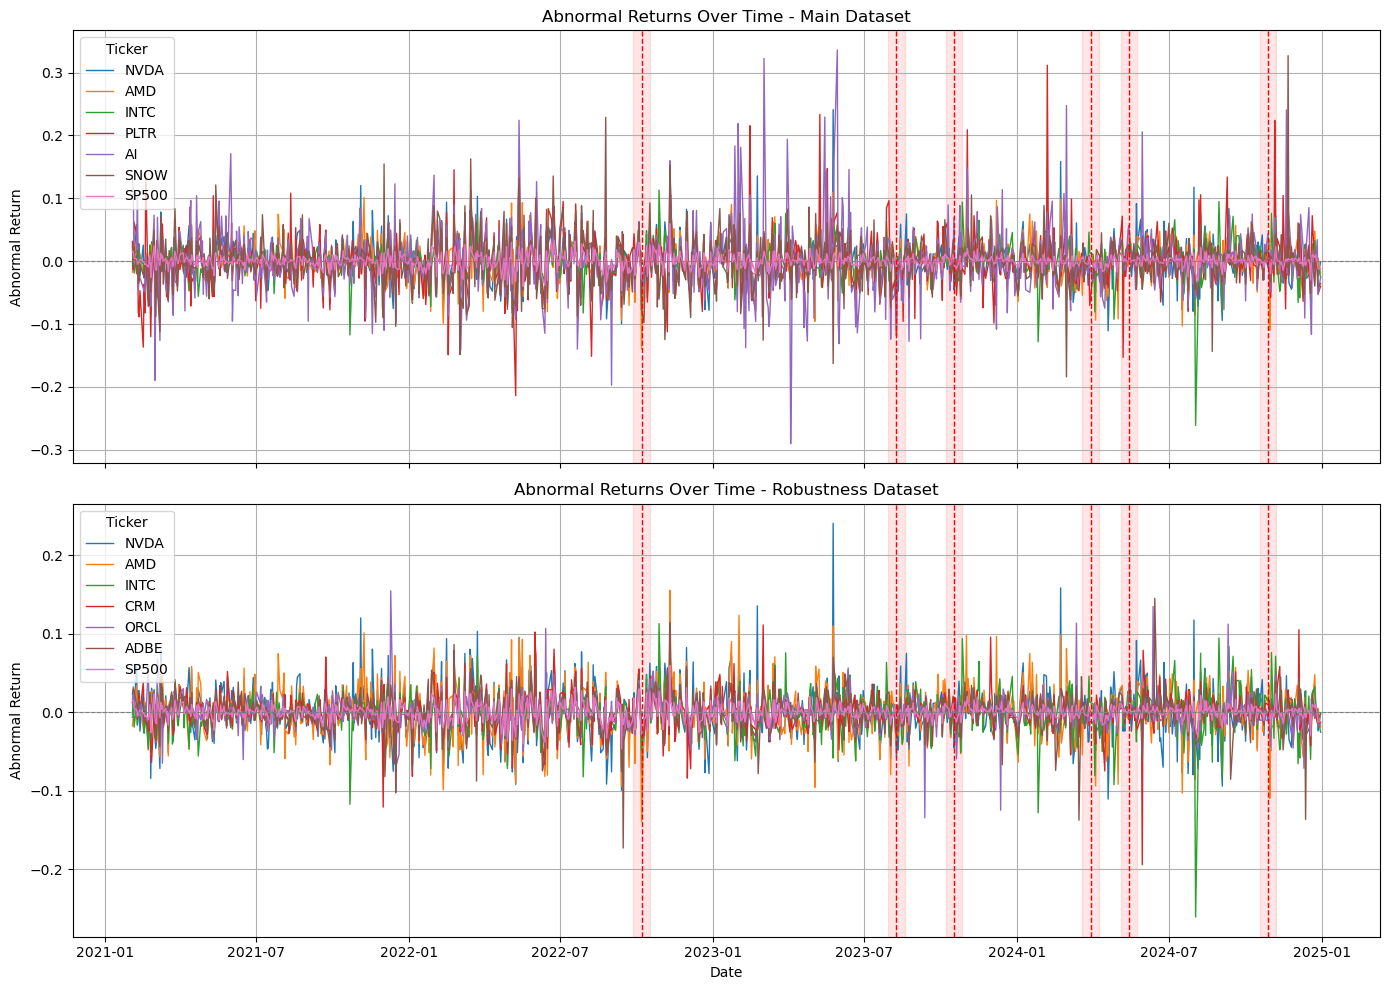

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load two datasets ===
main_df = pd.read_csv("main_df.csv", parse_dates=["Date", "event_date"])
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])

# === Define policy event dictionary ===
event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
    "2024_investment_finalization": pd.to_datetime("2024-10-28"),
}

# === Create subplots ===
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Function to plot abnormal returns with event shading
def plot_ar_series(ax, df, title):
    tickers = df["ticker"].unique()
    for ticker in tickers:
        sub = df[df["ticker"] == ticker]
        ax.plot(sub["Date"], sub["abnormal_return"], label=ticker, linewidth=1)
    
    # Add event lines and shaded windows
    for event_date in event_dict.values():
        ax.axvline(event_date, color='red', linestyle='--', linewidth=1)
        ax.axvspan(event_date - pd.Timedelta(days=10),
                   event_date + pd.Timedelta(days=10),
                   color='red', alpha=0.1)
    
    ax.set_title(title)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_ylabel("Abnormal Return")
    ax.grid(True)
    ax.legend(title="Ticker", loc="upper left")

# === Plot main_df (top) and robust_df (bottom) ===
plot_ar_series(axs[0], main_df, "Abnormal Returns Over Time - Main Dataset")
plot_ar_series(axs[1], robust_df, "Abnormal Returns Over Time - Robustness Dataset")

# Final plot formatting
plt.xlabel("Date")
plt.tight_layout()
plt.show()


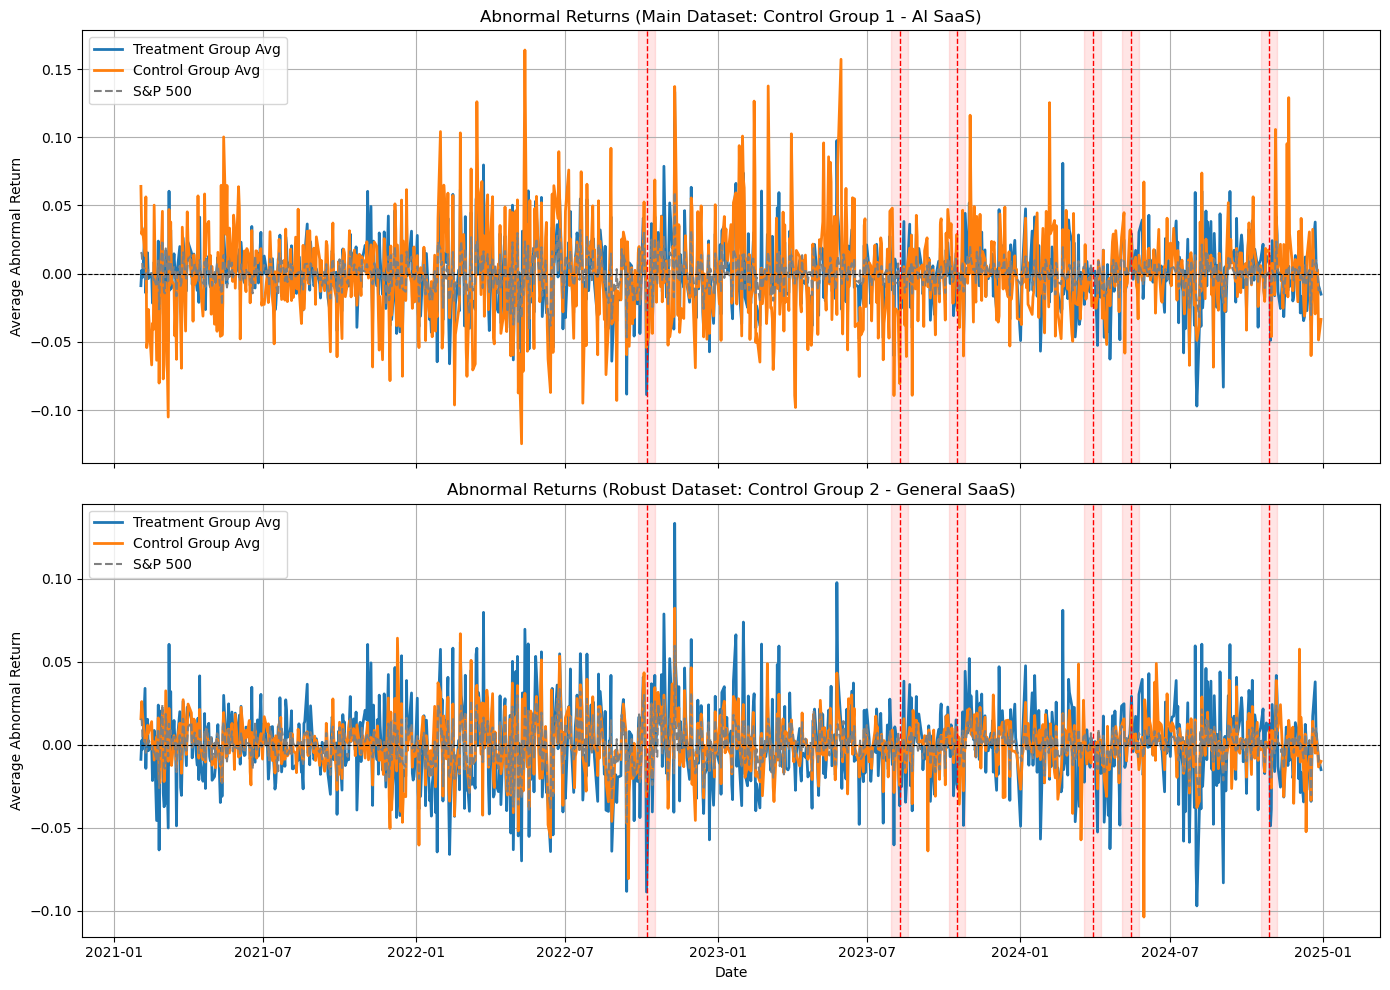

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load datasets ===
main_df = pd.read_csv("main_df.csv", parse_dates=["Date", "event_date"])
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])

# === Define policy event dictionary ===
event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
    "2024_investment_finalization": pd.to_datetime("2024-10-28"),
}

# === Define groups ===
treatment_group = ["NVDA", "AMD", "INTC"]
control_main = ["PLTR", "AI", "SNOW"]
control_robust = ["CRM", "ORCL", "ADBE"]
benchmark = "SP500"

# === Reusable plot function ===
def plot_group_avg(ax, df, control_group, title):
    # Group definitions
    df["Group"] = df["ticker"].apply(
        lambda x: "Treatment" if x in treatment_group else 
                  "Control" if x in control_group else 
                  "SP500" if x == benchmark else None
    )
    df = df[df["Group"].notna()]

    # Compute group-level average AR
    avg_df = df.groupby(["Date", "Group"])["abnormal_return"].mean().reset_index()
    avg_pivot = avg_df.pivot(index="Date", columns="Group", values="abnormal_return")

    # Plot average lines
    if "Treatment" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["Treatment"], label="Treatment Group Avg", linewidth=2)
    if "Control" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["Control"], label="Control Group Avg", linewidth=2)
    if "SP500" in avg_pivot.columns:
        ax.plot(avg_pivot.index, avg_pivot["SP500"], label="S&P 500", color='gray', linestyle='--')

    # Add policy event lines and shaded windows
    for event_date in event_dict.values():
        ax.axvline(event_date, color='red', linestyle='--', linewidth=1)
        ax.axvspan(event_date - pd.Timedelta(days=10),
                   event_date + pd.Timedelta(days=10),
                   color='red', alpha=0.1)

    ax.set_title(title)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_ylabel("Average Abnormal Return")
    ax.grid(True)
    ax.legend()

# === Create subplots ===
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === Plot for main_df (Control Group 1) ===
plot_group_avg(axs[0], main_df, control_main, "Abnormal Returns (Main Dataset: Control Group 1 - AI SaaS)")

# === Plot for robust_df (Control Group 2) ===
plot_group_avg(axs[1], robust_df, control_robust, "Abnormal Returns (Robust Dataset: Control Group 2 - General SaaS)")

# Final formatting
plt.xlabel("Date")
plt.tight_layout()
plt.show()


We find that Control Group 2—comprising large software firms such as Salesforce, Oracle, and Adobe—exhibits greater stability in abnormal returns and closer alignment with the market benchmark. This group appears less sensitive to AI and semiconductor-specific policy shocks, making it a more appropriate counterfactual for isolating the causal effect of hardware dependence. Therefore, we use Control Group 2 as our primary comparison group in the main Difference-in-Differences analysis.


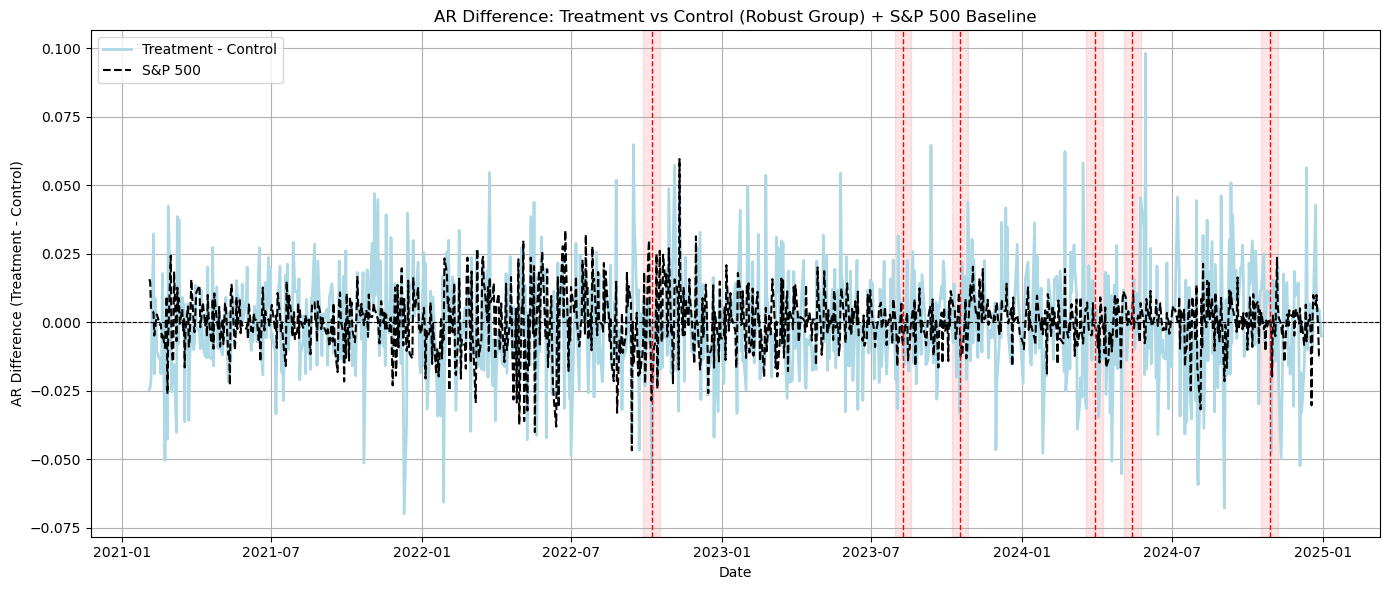

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load robust dataset ===
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])

# === Define groups ===
treatment_group = ["NVDA", "AMD", "INTC"]
control_group = ["CRM", "ORCL", "ADBE"]
benchmark = "SP500"

# === Define policy event dictionary ===
event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
    "2024_investment_finalization": pd.to_datetime("2024-10-28"),
}

# === Assign group labels ===
robust_df["Group"] = robust_df["ticker"].apply(
    lambda x: "Treatment" if x in treatment_group else 
              "Control" if x in control_group else 
              "SP500" if x == benchmark else None
)
robust_df = robust_df[robust_df["Group"].notna()]

# === Compute group-level average AR ===
avg_df = robust_df.groupby(["Date", "Group"])["abnormal_return"].mean().reset_index()
avg_pivot = avg_df.pivot(index="Date", columns="Group", values="abnormal_return").dropna()

# === Compute difference: Treatment - Control ===
avg_pivot["Treatment_Minus_Control"] = avg_pivot["Treatment"] - avg_pivot["Control"]

# === Plotting ===
plt.figure(figsize=(14, 6))

# Plot Treatment - Control difference
plt.plot(avg_pivot.index, avg_pivot["Treatment_Minus_Control"], label="Treatment - Control", color="lightblue", linewidth=2)

# Plot SP500 benchmark
if "SP500" in avg_pivot.columns:
    plt.plot(avg_pivot.index, avg_pivot["SP500"], label="S&P 500", color="black", linestyle="--")

# Add event vertical lines and shaded windows
for event_date in event_dict.values():
    plt.axvline(event_date, color='red', linestyle='--', linewidth=1)
    plt.axvspan(event_date - pd.Timedelta(days=10), event_date + pd.Timedelta(days=10), color='red', alpha=0.1)

# Final touches
plt.title("AR Difference: Treatment vs Control (Robust Group) + S&P 500 Baseline")
plt.xlabel("Date")
plt.ylabel("AR Difference (Treatment - Control)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We intentionally avoid relying on market return models (e.g., CAPM or Fama-French factors) when computing abnormal returns. Our analysis focuses on estimating the relative sensitivity of hardware-dependent AI firms compared to control firms, using pre-post differences in abnormal returns across multiple policy events. This design allows us to estimate causal effects without assuming that market-wide returns represent a valid counterfactual, which may be contaminated by the very policy shocks we study.


As shown in Above Figure, the difference in abnormal returns between hardware-dependent firms and control firms remains close to zero outside of policy event windows, consistent with the parallel trends assumption. Notably, around the dates of major AI-related trade policy announcements (e.g., export restrictions and investment bans), we observe sharp deviations in the AR difference, indicating that treatment firms responded more strongly than control firms. This pattern supports our causal hypothesis that hardware dependence amplifies firms’ sensitivity to trade war shocks.

